In [1]:
import pandas as pd
import os, shutil
import numpy as np

In [2]:
import tensorflow
from tensorflow.compat.v1.keras.backend import set_session
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tensorflow.compat.v1.Session(config=config)
set_session(sess)
import tensorflow.keras.backend as K

tensorflow.compat.v1.disable_eager_execution()

In [3]:
os.chdir("C:/Users/abbal/Documents/Py - Covid Xray Detection")

In [ ]:
## Create a folder for each set
TTV_Sets = ["test", "train", "validation"]
for st in TTV_Sets:
    os.mkdir(os.path.join("./Categorized" , st))

In [ ]:
## get file with labels
File_Labels = pd.read_csv("Chest_xray_Corona_Metadata.csv")

Unique_Labels = File_Labels["Label"].unique()
print(Unique_Labels)

In [ ]:
## Create a folder for each image
TTV_Sets = ["test", "train", "validation"]
for st in TTV_Sets:
    os.mkdir(os.path.join("./Categorized" , st))

for st in TTV_Sets:
    for i in Unique_Labels:     
        os.mkdir(os.path.join("./Categorized",st, i))

In [ ]:
## split labels to train, test and validation
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
train, validate, test = train_validate_test_split(File_Labels)

In [ ]:
## Move all files to their respective folder
for fl in range(train.shape[0]):
    Curr_FileName = train.iloc[fl, 0]
    Curr_FileName = str(Curr_FileName)
    Curr_DogBreed = train.iloc[fl, 1]
    Orig_file = os.path.join("./Raw Images", Curr_FileName)
    New_file = os.path.join("./Categorized/train",Curr_DogBreed, Curr_FileName)
    shutil.copyfile(Orig_file, New_file)

for fl in range(test.shape[0]):
    Curr_FileName = test.iloc[fl, 0]
    Curr_FileName = str(Curr_FileName)
    Curr_DogBreed = test.iloc[fl, 1]
    Orig_file = os.path.join("./Raw Images", Curr_FileName)
    New_file = os.path.join("./Categorized/test",Curr_DogBreed, Curr_FileName)
    shutil.copyfile(Orig_file, New_file)
    
for fl in range(validate.shape[0]):
    Curr_FileName = validate.iloc[fl, 0]
    Curr_FileName = str(Curr_FileName)
    Curr_DogBreed = validate.iloc[fl, 1]
    Orig_file = os.path.join("./Raw Images", Curr_FileName)
    New_file = os.path.join("./Categorized/validation",Curr_DogBreed, Curr_FileName)
    shutil.copyfile(Orig_file, New_file)

In [4]:
train_dir = os.path.join("./Categorized", 'train')
validation_dir = os.path.join("./Categorized", 'validation')
test_dir = os.path.join("./Categorized", 'test')

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(350, 350, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(215, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(600, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [8]:
# because an image can only obtain one classification, use sparse categorical
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['acc'])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(350, 350),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(350, 350),
        batch_size=20,
        class_mode='categorical')

Found 3546 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.


In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 350, 350, 3)
labels batch shape: (20, 2)


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 348, 348, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 174, 174, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 172, 172, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 86, 86, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 84, 84, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 512)      

In [11]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 204ms/step - loss: 0.5796 - acc: 0.7410 - val_loss: 0.5390 - val_acc: 0.7380
Epoch 2/100
100/100 [==============================] - 20s 199ms/step - loss: 0.4435 - acc: 0.7991 - val_loss: 0.3892 - val_acc: 0.8289
Epoch 3/100
100/100 [==============================] - 21s 209ms/step - loss: 0.3137 - acc: 0.8675 - val_loss: 0.2233 - val_acc: 0.9134
Epoch 4/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2794 - acc: 0.8802 - val_loss: 0.1925 - val_acc: 0.9348
Epoch 5/100
100/100 [==============================] - 21s 208ms/step - loss: 0.2162 - acc: 0.9145 - val_loss: 0.1835 - val_acc: 0.9409
Epoch 6/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2211 - acc: 0.9068 - val_loss: 0.1726 - val_acc: 0.9318
Epoch 7/100
100/100 [==============================] - 21s 207ms/step - loss: 0.2065 - acc: 0.9225 - val_loss: 0.1691 - val_acc: 0.9350
Epoch 8/100
100/100 [===========================

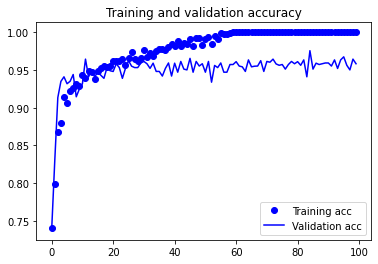

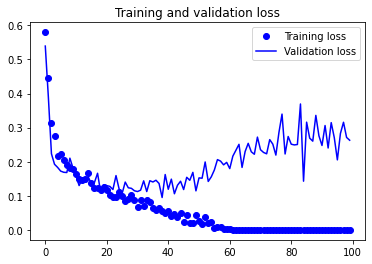

In [12]:
## Let's plot model performance
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

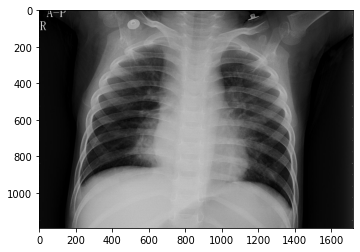

In [29]:
from tensorflow.keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions

# The local path to our target image
img_path = "./Categorized/train/Pnemonia/person142_virus_288.jpeg"

# `img` is a PIL image of size 224x224
img_actual = image.load_img(img_path)
img = image.load_img(img_path, target_size=(350, 350))

# `x` is a float32 Numpy array of shape (350, 350, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 300, 300, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

plt.imshow(img_actual)

In [30]:
## Get image prediction

preds = model.predict(x)
NumPredicted = np.argmax(preds[0])

Prediction_Dictionary = dict(zip(train_generator.class_indices, np.round(preds[0]*100,2)))
Sorted_Prediction_Dictionary = sorted(Prediction_Dictionary.items(), key=lambda x: x[1], reverse=True)

In [31]:
## How many have a prediction above 2%

TopPrediction= Sorted_Prediction_Dictionary[0]

print(TopPrediction)

('Pnemonia', 97.88)


In [32]:
preds = model.predict(x)
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
last_conv_layer = model.get_layer('conv2d_9')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(215):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

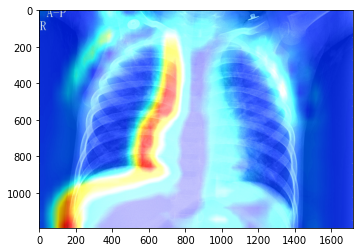

In [33]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.8 + img

cv2.imwrite('./Pneumonia - GRAD CAM.jpg', superimposed_img)

Grad_Image = image.load_img('./Pneumonia - GRAD CAM.jpg')
plt.imshow(Grad_Image)